# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Índice
1. [Introdução](#introducao)
2. [Sobre os dados](#sobre)
3. [Avaliação do modelo](#avaliacao)

## Introdução <a name="introdução"></a>

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado**.

Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). 


## Sobre os dados <a name="sobre"></a>

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies: Number of times pregnant

* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

* BloodPressure: Diastolic blood pressure (mm Hg)

* SkinThickness: Triceps skin fold thickness (mm)

* Insulin: 2-Hour serum insulin (mu U/ml)

* BMI: Body mass index (weight in kg/(height in m)^2)

* DiabetesPedigreeFunction: Diabetes pedigree function

* Age: Age (years)

* Outcome: Class variable (0 or 1)



## Avaliação do modelo <a name="avaliacao"></a>

A métrica que utilizaremos para avaliar o modelo será a **acurácia**. Compararemos nossos resultados com um modelo empírico baseado na taxa de glicose. 

## Importando e explorando os dados

In [182]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [183]:
data = pd.read_csv("data/diabetes.csv")

In [184]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [186]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [187]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos em {col}")

111 valores nulos em Pregnancies
5 valores nulos em Glucose
35 valores nulos em BloodPressure
227 valores nulos em SkinThickness
374 valores nulos em Insulin
11 valores nulos em BMI
0 valores nulos em DiabetesPedigreeFunction
0 valores nulos em Age
500 valores nulos em Outcome


Valores nulos de Glucose, BloodPressure, SkinThickness, Insulin e BMI são na verdade **NaN**. Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [188]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [189]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias `Glucose` e são relativamente homogêneas.

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

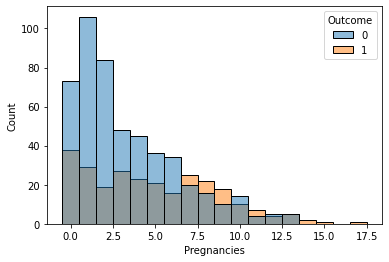

In [190]:
_ = sns.histplot(data, x="Pregnancies", hue="Outcome", discrete=True)

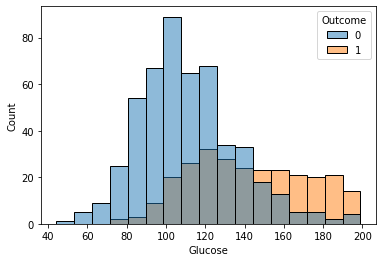

In [191]:
_ = sns.histplot(data[data["Glucose"] != 0], x="Glucose", hue="Outcome")

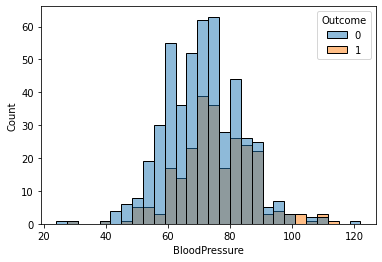

In [192]:
_ = sns.histplot(data[data["BloodPressure"] != 0], x="BloodPressure", hue="Outcome")

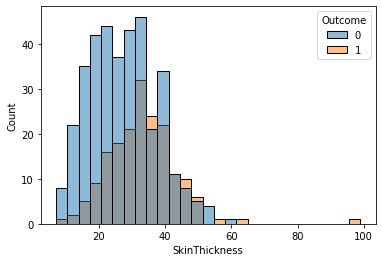

In [193]:
_ = sns.histplot(data[data["SkinThickness"] != 0], x="SkinThickness", hue="Outcome")

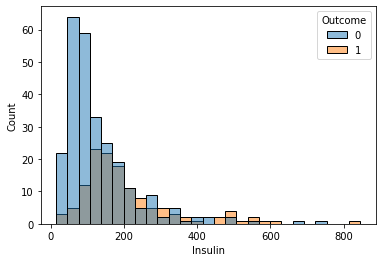

In [194]:
_ = sns.histplot(data[data["Insulin"] != 0], x="Insulin", hue="Outcome")

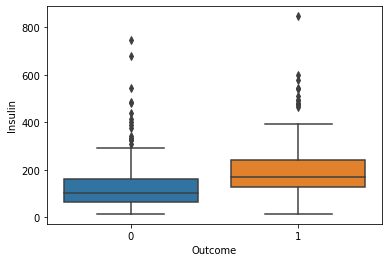

In [195]:
_ = sns.boxplot(data=data[data["Insulin"] != 0], x="Outcome", y="Insulin")

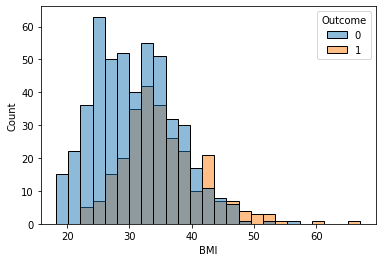

In [196]:
_ = sns.histplot(data[data["BMI"] != 0], x="BMI", hue="Outcome")

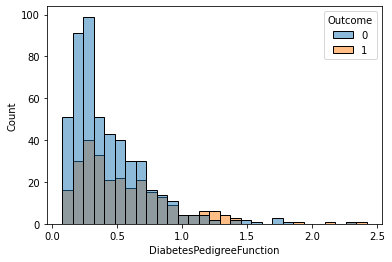

In [197]:
_ = sns.histplot(data, x="DiabetesPedigreeFunction", hue="Outcome")

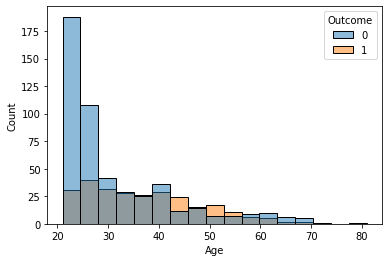

In [198]:
_ = sns.histplot(data, x="Age", hue="Outcome")

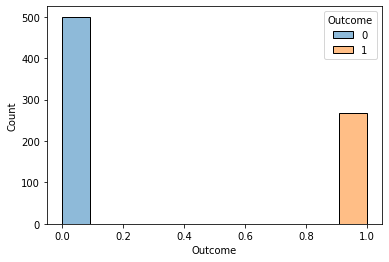

In [199]:
_ = sns.histplot(data, x="Outcome", hue="Outcome")

In [200]:
# Our data is not balanced: almost twice of the instances are not diabetic.

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


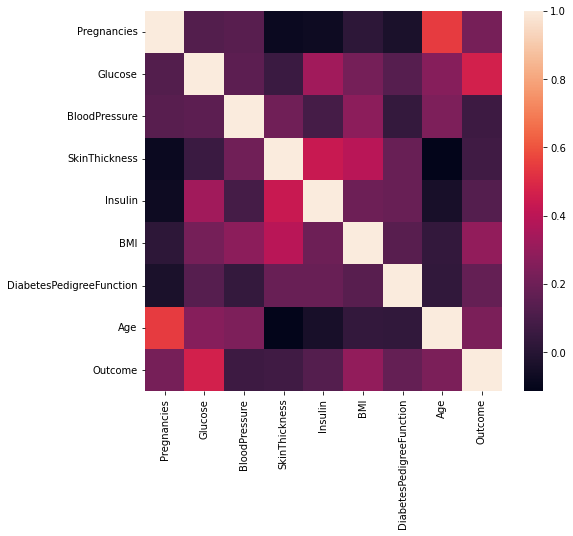

In [201]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))   

correlacao(data)

plt.figure(figsize=(8,7))
_ = sns.heatmap(data=data.corr())

In [202]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))    

## Baseline

In [203]:
# Aqui vem uma baseline empírica.

In [204]:
# Defining some metrics report functions

def cross_val_report(estimator, X_train, y_train):
    cv_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_mean_score = cv_score.mean()
    print(f"Mean accuracy score is: {np.round(cv_mean_score, 4)}")
    
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")

# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos pouca ou nenhum tratamento dos dados ou otimizações nos modelos no momento. 

Utilizaremos 85% dos dados como treino e as 116 instâncias restantes serão reservadas para teste no final da construção do modelo. Durante os treinos, como temos poucas instâncias para trabalhar, usaremos *cross validation*.

In [205]:
def relatorio_cross_val(estimator, X_train, y_train):
    """Calcula a acurácia média utilizando cross validation"""
    cv_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_mean_score = cv_score.mean()
    print(f"Acurácia média: {np.round(cv_mean_score, 4)}")

In [206]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [207]:
# Train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

Começaremos com uma *decision tree* para ganhar algum insight sobre os dados:

In [208]:
# Decision tree classifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

relatorio_cross_val(tree_clf, X_train, y_train)

Acurácia média: 0.7362


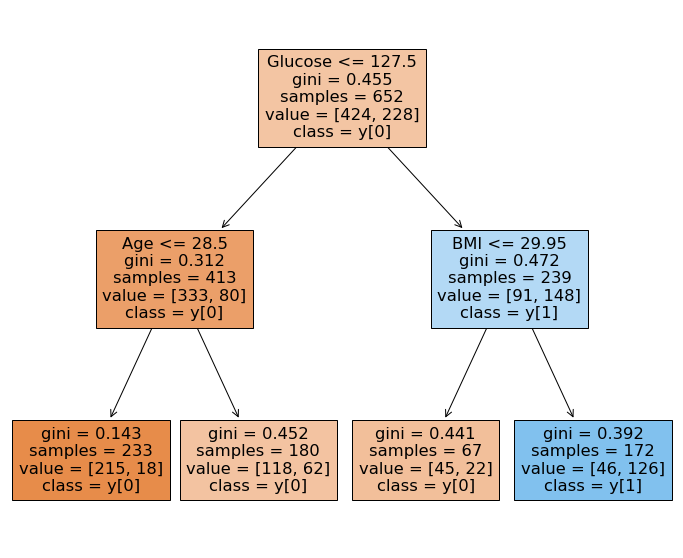

In [209]:
# Plotting tree

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore rasa, já temos uma acurácia média de 73,62%! Também confirmamos algumas expectativas: Glucose, Age e BMI são varíaveis importantes nesse problema.

Também podemos treinar uma regressão logística, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [210]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7622


Um pouco melhor: 76,22% de acúracia.

# Tratamento dos dados

Podemos limpar um pouco os dados antes de tentar modelos ML mais elaborados. Nessa seção, trataremos os dados faltantes e os outliers.

In [211]:
data_tr = data.copy()

### Lidando com dados faltantes

In [212]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_tr[col] = data_tr[col].replace(0, np.nan)

In [213]:
X = data_tr.drop("Outcome", axis=1)
y = data_tr["Outcome"]

In [214]:
# Train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

In [215]:
# Imputando com KNN

imp = KNNImputer()
X_train_tr = imp.fit_transform(X_train)

X_train_tr = pd.DataFrame(X_train_tr, columns=X_train.columns, index=X_train.index)

In [216]:
# Juntar features e target para analisar os resultados

X_train_tr_full = X_train_tr.join(y_train.to_frame())

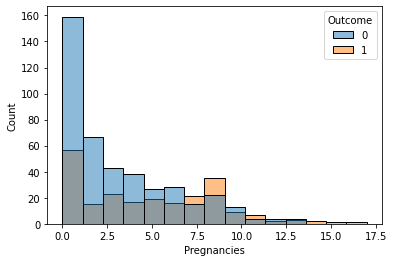

In [217]:
_ = sns.histplot(X_train_tr_full, x="Pregnancies", hue="Outcome")

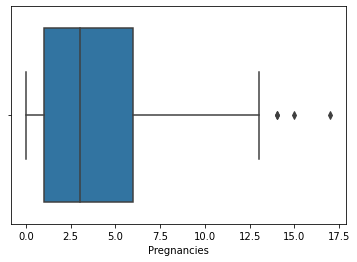

In [218]:
_ = sns.boxplot(data=X_train_tr_full, x="Pregnancies")

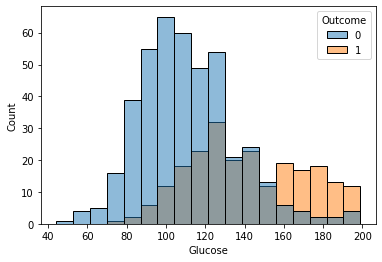

In [219]:
_ = sns.histplot(X_train_tr_full, x="Glucose", hue="Outcome")

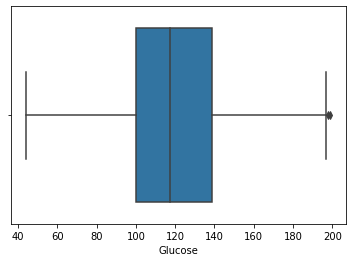

In [220]:
_ = sns.boxplot(data=X_train_tr_full, x="Glucose")

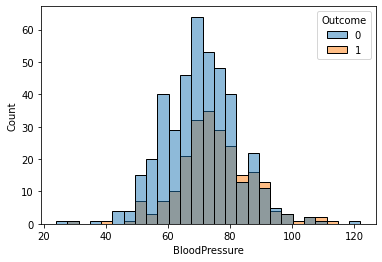

In [221]:
_ = sns.histplot(X_train_tr_full, x="BloodPressure", hue="Outcome")

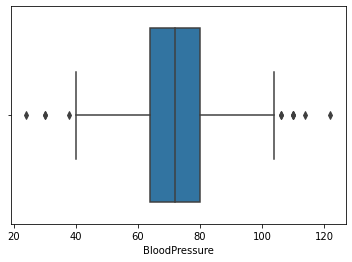

In [222]:
_ = sns.boxplot(data=X_train_tr_full, x="BloodPressure")

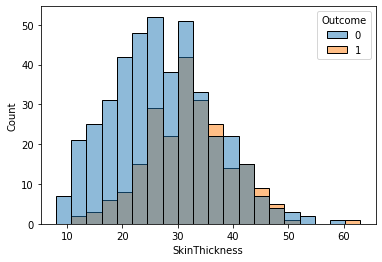

In [223]:
_ = sns.histplot(X_train_tr_full, x="SkinThickness", hue="Outcome")

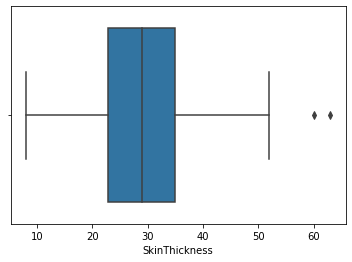

In [224]:
_ = sns.boxplot(data=X_train_tr_full, x="SkinThickness")

In [225]:
# Provavelmente não é muito relevante

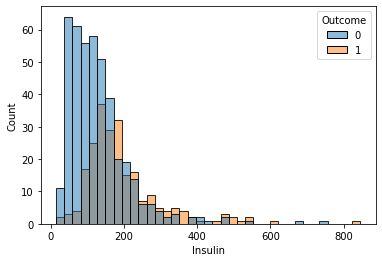

In [226]:
_ = sns.histplot(X_train_tr_full, x="Insulin", hue="Outcome")

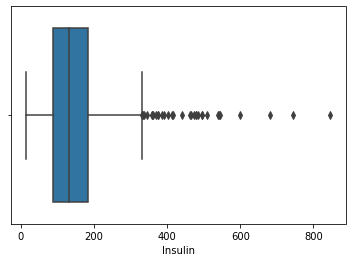

In [227]:
_ = sns.boxplot(data=X_train_tr_full, x="Insulin")

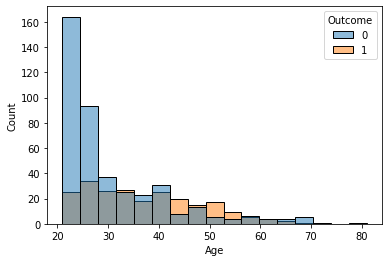

In [228]:
_ = sns.histplot(X_train_tr_full, x="Age", hue="Outcome")

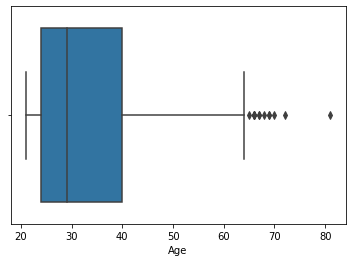

In [229]:
_ = sns.boxplot(data=X_train_tr_full, x="Age")

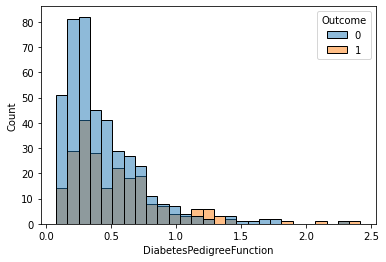

In [231]:
_ = sns.histplot(X_train_tr_full, x="DiabetesPedigreeFunction", hue="Outcome")

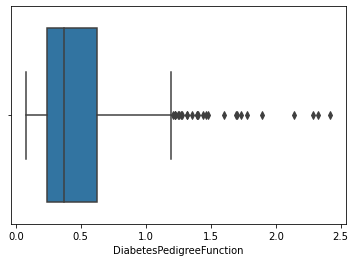

In [232]:
_ = sns.boxplot(data=X_train_tr_full, x="DiabetesPedigreeFunction")

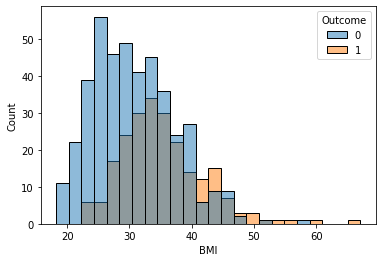

In [233]:
_ = sns.histplot(X_train_tr_full, x="BMI", hue="Outcome")

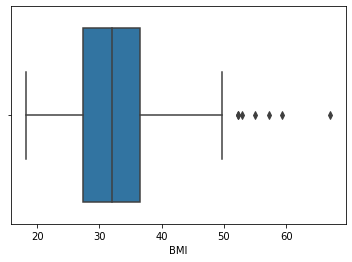

In [234]:
_ = sns.boxplot(data=X_train_tr_full, x="BMI")

In [235]:
corr_matrix = X_train_tr_full.corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.497140
Insulin                     0.319874
BMI                         0.316636
Age                         0.278958
SkinThickness               0.264017
Pregnancies                 0.233916
BloodPressure               0.179250
DiabetesPedigreeFunction    0.158570
Name: Outcome, dtype: float64


In [236]:
# Decision tree classifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train_tr, y_train)

relatorio_cross_val(tree_clf, X_train_tr, y_train)

Acurácia média: 0.7531


In [237]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7622


### Tratando outliers

In [289]:
X_train_tr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin
227,3.0,162.0,52.0,38.0,37.2,24.0,-0.427711,5.581991
168,4.0,110.0,66.0,33.6,31.9,29.0,-0.752897,4.755313
513,2.0,91.0,62.0,20.2,27.3,22.0,-0.644357,4.074142
7,10.0,115.0,77.6,34.4,35.3,29.0,-2.009915,4.887337
196,1.0,105.0,58.0,21.2,24.3,21.0,-1.676647,4.980863


In [306]:
from scipy.stats.mstats import winsorize

#X_train_tr["BMI_win"] = winsorize(X_train_tr["BMI"], limits=(0.01, 0.02))
X_train_tr["BloodPressure_win"] = winsorize(X_train_tr["BloodPressure"], limits=(0.01, 0.02))


In [307]:
correlacao(X_train_tr.join(y_train.to_frame()))

Outcome                        1.000000
Glucose                        0.497140
LogInsulin                     0.371472
BMI_win                        0.316869
BMI                            0.316636
Age                            0.278958
SkinThickness                  0.264017
Pregnancies                    0.233916
BloodPressure_win              0.185121
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
Name: Outcome, dtype: float64


O gráfico da `DiabetesPedigreeFunction` parecia muito inviesado. Aplicar um logáritimo torna ela mais normal:

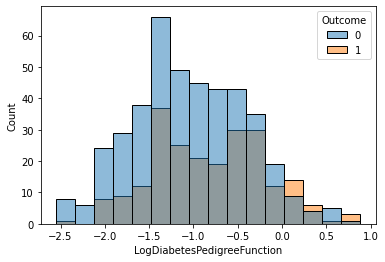

In [239]:
X_train_tr_full['LogDiabetesPedigreeFunction'] = np.log(X_train_tr_full['DiabetesPedigreeFunction'])
_ = sns.histplot(X_train_tr_full, x="LogDiabetesPedigreeFunction", hue="Outcome")

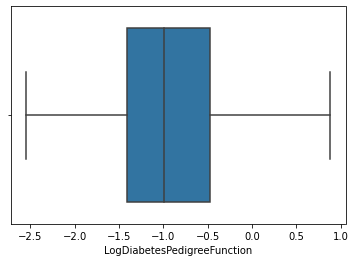

In [240]:
_ = sns.boxplot(data=X_train_tr_full, x="LogDiabetesPedigreeFunction")

In [241]:
X_train_tr['LogDiabetesPedigreeFunction'] = np.log(X_train_tr['DiabetesPedigreeFunction'])
X_train_tr.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

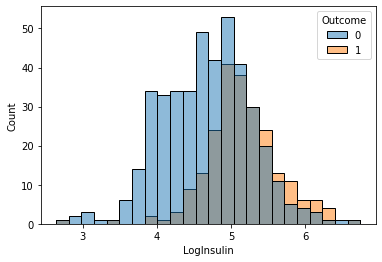

In [242]:
X_train_tr_full['LogInsulin'] = np.log(X_train_tr_full['Insulin'])
_ = sns.histplot(X_train_tr_full, x="LogInsulin", hue="Outcome")

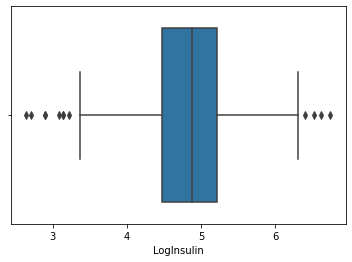

In [243]:
_ = sns.boxplot(data=X_train_tr_full, x="LogInsulin")

In [244]:
X_train_tr['LogInsulin'] = np.log(X_train_tr['Insulin'])
X_train_tr.drop('Insulin', axis=1, inplace=True)

In [245]:
X_train_tr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin
227,3.0,162.0,52.0,38.0,37.2,24.0,-0.427711,5.581991
168,4.0,110.0,66.0,33.6,31.9,29.0,-0.752897,4.755313
513,2.0,91.0,62.0,20.2,27.3,22.0,-0.644357,4.074142
7,10.0,115.0,77.6,34.4,35.3,29.0,-2.009915,4.887337
196,1.0,105.0,58.0,21.2,24.3,21.0,-1.676647,4.980863


In [246]:
correlacao(X_train_tr_full)

Outcome                        1.000000
Glucose                        0.497140
LogInsulin                     0.371472
Insulin                        0.319874
BMI                            0.316636
Age                            0.278958
SkinThickness                  0.264017
Pregnancies                    0.233916
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
DiabetesPedigreeFunction       0.158570
Name: Outcome, dtype: float64


In [247]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7607


### Binning

In [248]:
X_train_bin_full = X_train_tr_full.copy()

In [249]:
X_train_bin_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogDiabetesPedigreeFunction,LogInsulin
227,3.0,162.0,52.0,38.0,265.6,37.2,0.652,24.0,1,-0.427711,5.581991
168,4.0,110.0,66.0,33.6,116.2,31.9,0.471,29.0,0,-0.752897,4.755313
513,2.0,91.0,62.0,20.2,58.8,27.3,0.525,22.0,0,-0.644357,4.074142
7,10.0,115.0,77.6,34.4,132.6,35.3,0.134,29.0,0,-2.009915,4.887337
196,1.0,105.0,58.0,21.2,145.6,24.3,0.187,21.0,0,-1.676647,4.980863


Para `Age` usaremos KBinsDiscretizer:

In [250]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal')
X_train_bin_full["New_Age"] = kbins.fit_transform(X_train_bin_full[['Age']])
X_train_bin_full.drop('Age', axis=1, inplace=True)

In [251]:
correlacao(X_train_bin_full)

Outcome                        1.000000
Glucose                        0.497140
LogInsulin                     0.371472
New_Age                        0.349550
Insulin                        0.319874
BMI                            0.316636
SkinThickness                  0.264017
Pregnancies                    0.233916
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
DiabetesPedigreeFunction       0.158570
Name: Outcome, dtype: float64


In [252]:
X_train_bin = X_train_bin_full.drop('Outcome', axis=1)

In [253]:
# Decision tree classifier

log_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train_bin, y_train)

relatorio_cross_val(tree_clf, X_train_bin, y_train)

Acurácia média: 0.7531


In [254]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_bin)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7714


## Modelo final

In [255]:
X_train = X_train_bin.copy()

In [256]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
relatorio_cross_val(forest_clf, X_train, y_train)

Acurácia média: 0.7577


In [257]:
# params = {"n_estimators":np.linspace(100,1000,4, dtype=np.int), 
#           "max_depth":np.linspace(1,7,4, dtype=np.int),
#           "min_samples_split": [2,5,10,30],
#           "max_features": [3,5,7]
#          }
# grid_search_cv = GridSearchCV(forest_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)

In [258]:
# grid_search_cv.best_estimator_

In [259]:
# grid_search_cv.best_score_

In [260]:
# from xgboost import XGBClassifier

# xgb_clf = XGBClassifier(random_state=42)

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)

In [261]:
# grid_search_cv.best_estimator_

In [262]:
# grid_search_cv.best_score_

In [263]:
# xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, random_state=42, n_estimators=500)
# xgb_clf.fit(X_train, y_train)
# relatorio_cross_val(xgb_clf, X_train, y_train)

## Feature engineering